import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pylab as plt
from keras.preprocessing import image
from tensorflow.keras import utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import time

2023-05-10 13:06:32.721099: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 13:06:33.377259: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 13:06:33.384072: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 13:06:35.637844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


functions

In [34]:
SAVED_MODEL_BEST_ACCURACY_RESULTS = []
SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS = []
SAVED_MODEL_BEST_ACCURACY_RESULTS2 = []
SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS2 = []
IMG_SIZE = 64
EPOCHS = 200 # try different

In [3]:
def get_image_and_transform(path):
    data = utils.load_img(path, color_mode='grayscale', target_size=(64, 64))
    data = utils.img_to_array(data)
    data = np.expand_dims(data, axis=0)
    data = data / 255.0
    return data

In [4]:
def build_dataset(dataset_dir): # build 2 datasets for training and testing
    x_train, y_train = [], []
    classes = sorted(os.listdir(dataset_dir))
    for i in range(len(classes)):
        class_dir = os.path.join(dataset_dir, classes[i])
        images = os.listdir(class_dir)
        for image in images:
            full_image_path = os.path.join(class_dir, image)
            if 'ipynb_checkpoints' in full_image_path:
                continue
            x_train.append(get_image_and_transform(full_image_path))
            y_train.append(i)
    return x_train, y_train

In [5]:
def get_examples_and_classes(dataset_dir, num): # return persons' names and persons' ears
    classes = sorted(os.listdir(dataset_dir))
    examples = []
    for i in range(len(classes)):
        class_dir = os.path.join(dataset_dir, classes[i])
        images = os.listdir(class_dir)
        examples.append(os.path.join(class_dir, images[num]))

    return classes, examples

In [6]:
def plot(accuracy, loss, val_accuracy, val_loss): # return schedule of accuracy and loss
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('epoch')

    ax1.set_ylabel('total loss')
    ax1.plot(loss,color='tab:red')
    ax1.plot( val_loss, color='tab:brown')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('accuracy')  
    ax2.plot( accuracy, color='tab:blue')
    ax2.plot( val_accuracy, color='tab:green')
    ax2.tick_params(axis='y')
    fig.tight_layout()

In [7]:
def plot_many(title='title', data=[]): # return schedules of accuracy
    for i,o in enumerate(data):
        plt.figure(i)
        plt.plot([i for i in range(EPOCHS)],o, label=title)
        plt.legend(loc='upper left')

In [8]:
def max_or_min_avarage_val(list_of_data, accuracy=True): #return dictionary of average values of lists
    dict_all_l = {}
    for i, o in enumerate(list_of_data):
        dict_all_l[i] = sum(o)/len(o)
    if accuracy:
        return dict(sorted(dict_all_l.items(), key=lambda item: item[1], reverse=True))
    else:
        return dict(sorted(dict_all_l.items(), key=lambda item: item[1]))

In [9]:
def save_lists(): # save lists of accuracy and loss
    t = time.ctime(time.time())[:-5]
    with open(f'accuracy {t}.txt', 'w') as f:
        for item in SAVED_MODEL_BEST_ACCURACY_RESULTS:
            f.write("%s\n" % item)
    with open(f'val_accuracy {t}.txt', 'w') as f:
        for item in SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS:
            f.write("%s\n" % item)

In [10]:
def read_list_from_file(filename): # read accuracy or loss data  from files
    lst = []
    with open(filename, 'r') as file:
        for line in file.readlines():
            if line in ('', ' ','\n'):
                break
            line = line[1:-2].split(', ')
            lst.append([float(i.strip()) for i in line])
    return lst

In [11]:
def show_best_res(list_of_data): # return max value in every list of accuracy
    max_val = {}
    for i, o in enumerate(list_of_data):
        max_val[i] = max(o)
    return dict(sorted(max_val.items(), key=lambda item: item[1], reverse=True))

dataset

In [12]:
train_folder = "/home/jovyan/dataset/dataset2/train"
test_folder = "/home/jovyan/dataset/dataset2/test"

In [13]:
train_datagen = ImageDataGenerator()#rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator()#rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 color_mode='grayscale')

test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size = (64, 64),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            color_mode='grayscale')

# print(training_set.filepaths)
# print(training_set.classes)
# print(training_set.class_indices)


Found 22736 images belonging to 164 classes.
Found 5683 images belonging to 164 classes.


model

In [35]:
def model(in_1=32, in_2=32, in_3=32, in_4=64):
    model = Sequential()
    model.add(Conv2D(filters=in_1,kernel_size=5, strides=(1,1), input_shape=(64,64,1), padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())
    

    model.add(Conv2D(filters=in_2,kernel_size=5, strides=1, padding = 'same', activation = 'relu')) # try elu
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=in_3,kernel_size=5, strides=1, padding ='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())
    
    
    model.add(Conv2D(filters=in_4,kernel_size=5, strides=1, padding ='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    # model.add(tf.keras.layers.Dropout(0.1))
    # model.add(Dense(units = 512 , activation = 'tanh')) # try delete
    # model.add(Dense(units = 1))
    model.add(Dense(units = 164 , activation = 'softmax'))

    model.compile( optimizer='Adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

    return model
summary_example = model()
summary_example.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 64, 64, 32)        832       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        25632     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

choose best hyperparameters

In [36]:
def model_and_best_hyperparameters(nums):
    start_time1 = time.time() 
    for i in nums:
        start_time2 = time.time()
        
        ready_model = model(i,i*2,i*3, i*4)        # change order 
        trained_model = ready_model.fit(training_set, steps_per_epoch = 32, epochs = EPOCHS, validation_data = test_set)
        
        print("for one training time taken: {:.2f} seconds".format(time.time() - start_time2)) # how much time one training take

        SAVED_MODEL_BEST_ACCURACY_RESULTS.append(trained_model.history['accuracy'])
        SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS.append(trained_model.history['val_accuracy'])
        
    print("for all training time taken: {:.2f} seconds".format(time.time() - start_time1)) # how much time all training take

In [38]:
model_and_best_hyperparameters([32])

Epoch 1/200


2023-05-10 19:36:52.268220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - ETA: 0s - loss: 5.9628 - accuracy: 0.0137

2023-05-10 19:37:01.966797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 29s 903ms/step - loss: 5.9628 - accuracy: 0.0137 - val_loss: 98.4404 - val_accuracy: 0.0055
Epoch 2/200
32/32 [==============================] - 27s 865ms/step - loss: 5.8410 - accuracy: 0.0215 - val_loss: 33.4581 - val_accuracy: 0.0081
Epoch 3/200
32/32 [==============================] - 22s 701ms/step - loss: 5.7598 - accuracy: 0.0283 - val_loss: 10.3300 - val_accuracy: 0.0174
Epoch 4/200
32/32 [==============================] - 22s 700ms/step - loss: 5.4756 - accuracy: 0.0352 - val_loss: 8.6311 - val_accuracy: 0.0241
Epoch 5/200
32/32 [==============================] - 22s 714ms/step - loss: 5.4576 - accuracy: 0.0317 - val_loss: 6.2455 - val_accuracy: 0.0292
Epoch 6/200
32/32 [==============================] - 22s 705ms/step - loss: 5.2676 - accuracy: 0.0508 - val_loss: 6.9944 - val_accuracy: 0.0231
Epoch 7/200
32/32 [==============================] - 22s 702ms/step - loss: 5.2184 - accuracy: 0.0645 - val_loss: 5.4818 - val_accuracy: 0.0354
E

In [40]:
print("sorted list of max  epochs' values for accuracy  ", show_best_res(SAVED_MODEL_BEST_ACCURACY_RESULTS))
print("sorted list of max  epochs' values for val_accuracy  ", show_best_res(SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS))
# save_lists()  #val accuracy 0.46

sorted list of max  epochs' values for accuracy   {0: 0.9638671875}
sorted list of max  epochs' values for val_accuracy   {0: 0.46331164240837097}


In [18]:
# file = 'accuracy Sat May  6 11:19:23.txt'
# l = read_list_from_file(file)
# print("sorted list of max  epochs' values for accuracy  ", show_best_res(l))

train and save model

In [31]:
def final_model():
    ready_model = model(64,64,32,32)
    call_back = ModelCheckpoint(f"/home/jovyan/weights.hdf5", monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
    trained_model = ready_model.fit(training_set, steps_per_epoch = 32, epochs = EPOCHS, validation_data = test_set, callbacks = [call_back])
    
    SAVED_MODEL_BEST_ACCURACY_RESULTS2.append(trained_model.history['accuracy'])
    SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS2.append(trained_model.history['val_accuracy'])
    return trained_model, ready_model


In [32]:
history, trained_model = final_model()

Epoch 1/200


2023-05-10 17:50:58.543134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - ETA: 0s - loss: 5.5754 - accuracy: 0.0050

2023-05-10 17:51:08.023730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 25s 777ms/step - loss: 5.5754 - accuracy: 0.0050 - val_loss: 24.4009 - val_accuracy: 0.0069
Epoch 2/200
32/32 [==============================] - 23s 730ms/step - loss: 5.2120 - accuracy: 0.0205 - val_loss: 12.8697 - val_accuracy: 0.0099
Epoch 3/200
32/32 [==============================] - 23s 731ms/step - loss: 5.1663 - accuracy: 0.0303 - val_loss: 12.2715 - val_accuracy: 0.0107
Epoch 4/200
32/32 [==============================] - 23s 736ms/step - loss: 5.0514 - accuracy: 0.0215 - val_loss: 8.2028 - val_accuracy: 0.0174
Epoch 5/200
32/32 [==============================] - 23s 719ms/step - loss: 4.9013 - accuracy: 0.0303 - val_loss: 5.9064 - val_accuracy: 0.0225
Epoch 6/200
32/32 [==============================] - 23s 726ms/step - loss: 4.8688 - accuracy: 0.0371 - val_loss: 5.4551 - val_accuracy: 0.0273
Epoch 7/200
32/32 [==============================] - 23s 721ms/step - loss: 4.8539 - accuracy: 0.0361 - val_loss: 5.1027 - val_accuracy: 0.0341
E

plot model

In [21]:
# plot_many('accuracy', SAVED_MODEL_BEST_ACCURACY_RESULTS)

sorted list of max  epochs' values for accuracy   {0: 0.8271484375}
sorted list of max  epochs' values for val_accuracy   {0: 0.40471580624580383}


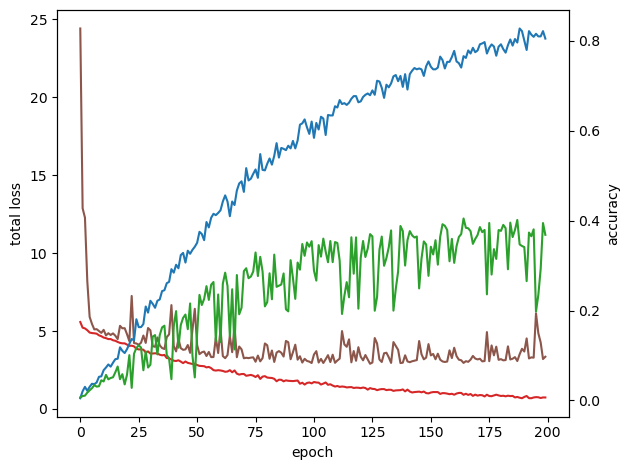

In [33]:
if trained_model:
    print("sorted list of max  epochs' values for accuracy  ", show_best_res(SAVED_MODEL_BEST_ACCURACY_RESULTS2))
    print("sorted list of max  epochs' values for val_accuracy  ", show_best_res(SAVED_MODEL_BEST_VAL_ACCURACY_RESULTS2))
    plot(history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss'])
    # save_lists()

predict

In [ ]:
predict_model = Sequential()
for layer in trained_model.layers[:-1]:
    predict_model.add(layer)
predict_model.add(Dense(units=1, activation=None))
predict_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
predict_model.summary()


predict_model.load_weights('weights.hdf5', skip_mismatch=True, by_name=True)

# # Load weights and biases from model manually
# for i in range(len(predict_model.layers) - 1):
#     predict_model.layers[i].set_weights(model.layers[i].get_weights())


In [ ]:
def predict(model, known_data_path, unknown_data_path):
    known_data = get_image_and_transform(known_data_path)
    unknown_data = get_image_and_transform(unknown_data_path)

    known_data = model.predict(known_data)
    unknown_data = model.predict(unknown_data)
    distance = unknown_data - known_data

    threshold = 0.018614814   # try logistic regression or support vector machine
    return  distance[0][0] < threshold, distance[0][0]

predict(predict_model, '/home/jovyan/12.jpg', '/home/jovyan/22.jpg')

plot prediction

In [ ]:
classes, examples1 = get_examples_and_classes(test_folder,1)
classes, examples2 = get_examples_and_classes(test_folder,2)
y_true = [i for i in range(len(classes))]
y_predict_tensors = []
y_predict_labels = []

for i in range(len(classes)):  # try build histogram
    predict_label, predict_tensor = predict(predict_model, examples1[i], examples2[i])
    y_predict_tensors.append(predict_tensor)
    y_predict_labels.append(predict_label)    

In [ ]:
print(classification_report(y_true, y_predict_labels, target_names=classes))

choose best threshold

In [ ]:
thresholds = np.linspace(0.0001, 0.5, 1000)

# Calculate F1 score for each threshold
f1_scores = []
for threshold in thresholds:
    y_pred = (y_predict_tensors < threshold).astype(int)
    f1_scores.append(f1_score(y_true, y_pred, average='micro'))

# Choose the threshold that maximizes F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
best_threshold